# SDCA

On commence par mettre en place un algorithme SDCA classique

### Génération des données

In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from prettytable import PrettyTable

np.random.seed(0)

n_samples, n_features = 10000, 25
X = np.random.randn(n_features, n_samples)
w_real = np.random.randn(n_features)
y = np.sign(np.dot(X.T,w_real) + np.random.randn(n_samples))

### Définition des fonctions de perte

> On introduit un wrapper, au cas où l'on souhaite tester d'autres fonctions de perte

In [216]:
class LossFunc:
    
    def __init__(self):
        self.primal = None
        self.dual = None
        self.sdca_update = None
        self.sgd_update = None
        self.pegasos_batch_update = None
    
    def set_primal(self, func):
        self.primal = func
    
    def set_dual(self, func):
        self.dual = func
    
    def set_sdca_update(self, func):
        self.sdca_update = func
    
    def set_sgd_update(self, func):
        self.sgd_update = func
    
    def set_pegasos_batch_update(self, func):
        self.pegasos_batch_update = func

#### Hinge loss

On applique le wrapper à la hinge loss

In [217]:
# Perte primale
def hinge_loss(a, y):
    """
        y: label
        a: prediction
    """
    return np.maximum(0, 1 - y * a)

# Duale
def hinge_dual(u, y):
    """
        y: label
        u: prediction
    """
    prod = u * y
    prod[prod > 0] = np.inf
    prod[prod < -1] = np.inf
    return prod

# Update de alpha
def hinge_update(y, w, x, n, lamb, alpha, gamma=0):
    # p.577 du papier
    """
        Update alpha pour la hinge loss
        y: label
        w: poids actuels
        x: inputs
        n: nombre de samples
        lamb: step
        alpha: variable du dual (reel)
        gamma: smoothness
    """
    n=x.shape[0]
    minim = min(1, ((1-np.dot(x.T,w)*y)*n*lamb/(np.power(np.linalg.norm(x), 2))+alpha*y))
    delta_alpha = y* max(0, minim)-alpha
    return (delta_alpha) 

hinge = LossFunc()
hinge.set_primal(hinge_loss)
hinge.set_dual(hinge_dual)
hinge.set_sdca_update(hinge_update)

#### Smoothed hinge loss

In [218]:
# On définit la fonction qui update alpha pour la hinge loss
    
    
# On définit la fonction qui update alpha pour la absolute deviation loss 
def update_absolute_deviation_loss(y, w, x, n, lamb, alpha, gamma=0):
    """
        Update alpha pour la absolute deviation loss
        y: label
        w: poids actuels
        x: inputs
        n: nombre de samples
        lamb: step
        alpha: variable du dual
        gamma: smoothness
    """
    minim = min(1, ((y-np.dot(x.T,w))/(np.power(np.linalg.norm(x), 2)/(lamb*n)))+alpha)
    delta_alpha = max(-1, minim)-alpha
    return (delta_alpha)

# On définit la fonction qui update alpha pour la smooth hinge loss 
def update_smoothed_hinge_loss(y, w, x, n, lamb, alpha, gamma):
    """
        Update alpha pour la smoothed hinge loss 
        y: label
        w: poids actuels
        x: inputs
        n: nombre de samples
        lamb: step
        alpha: variable du dual
        gamma: smoothness
    """
    minim = min(1, ((1-np.dot(x.T,w)*y-gamma*alpha*y)/(np.power(np.linalg.norm(x), 2/(lamb*n+gamma)))+alpha*y)
    delta_alpha = y*max(0, minim)-alpha
    return (delta_alpha)

SyntaxError: invalid syntax (<ipython-input-218-73140c78bcb6>, line 33)

### Définition de l'algorithme

#### Fonctions intermédiaires

On commence par mettre en place plusieurs fonctions qui vont nous être utiles dans l'algorithme

In [219]:
def w_from_alpha(alpha, X, lamb):
    """
        Obtenir les poids w du primal a partir de alpha
        alpha: vecteur de poids dans le dual
        X: variables explicatives
        lamb: regularisation
    """
    n = X.shape[1]
    return (1 / (n * lamb)) * np.dot(X,alpha)

In [220]:
# La def est p.573 du papier
def cum_loss_primal(w, X, y, lamb, lossfunction):
    """
        Calculer la loss primale cumulee (inclut penalisation)
        w: vecteur de poids dans le primal
        X: variables explicatives
        y: label a predire
        lamb: regularisation
        lossfunction: choix du type de perte
    """
    cumloss = np.mean(lossfunction.primal(np.dot(X.T,w), y))
    penal = (lamb / 2) * np.power(np.linalg.norm(w), 2)
    return cumloss + penal

In [221]:
# La def est p.573 du papier
def cum_loss_dual(alpha, X, y, lamb, lossfunction):
    """
        Calculer la loss duale cumulee (inclut penalisation)
        alpha: vecteur de poids dans le dual
        X: variables explicatives
        y: label a predire
        lamb: regularisation
        lossfunction: choix du type de perte
    """   
    # On doit d'abord extraire w de alpha
    w = w_from_alpha(alpha, X, lamb)
    cumloss = np.mean(- lossfunction.dual(- alpha, y))
    penal = -(lamb / 2) * np.power(np.linalg.norm(w), 2)
    return cumloss + penal

In [222]:
def duality_gap(alpha, X, y, lamb, lossfunction):
    """
        Calcule le duality gap (diff des loss)
        alpha: vecteur de poids dans le dual
        X: variables explicatives
        y: label a predire
        lamb: regularisation
    """
    # On doit d'abord extraire w de alpha
    w = w_from_alpha(alpha, X, lamb)
    primal = cum_loss_primal(w, X, y, lamb, lossfunction)
    dual = cum_loss_dual(alpha, X, y, lamb, lossfunction)
    return primal - dual

#### Algorithme

On passe ensuite a l'algorithme a proprement parler

In [256]:
def SDCA (X, y, T, lossfunction, gamma, T_0_ratio, epsilon, lamb):
    """
        Algorithme SDCA classique
        X: variables explicatives
        y: label a predire
        T: nombre d'epoch
        lossfunction: choix de la loss function
        gamma: parametre de smoothing, 1 etant tres smooth
        T_0_ratio: fraction qui indique quelle part des iterations on conserve
                    pour moyenner et obtenir alpha et w finaux
        lamb: regularisation
    """
    n_samples = X.shape[1]
    n_features=X.shape[0]
    Alpha=[]
    alpha= [0] * n_samples
    Alpha.append(alpha.copy())
    
    # On enregistre la primal loss
    primal_loss_track = []
    w = w_from_alpha(alpha, X, lamb)
    primal_loss_track.append(cum_loss_primal(w, X, y, lamb, lossfunction))
    
    # On enregistre la dual loss
    dual_loss_track = []
    dual_loss_track.append(cum_loss_dual(np.array(Alpha[0]), X, y, lamb, lossfunction))
    
    # On enregistre le duality gap
    gaps_track = []
    gap = duality_gap(np.array(Alpha[0]), X, y, lamb, lossfunction)
    gaps_track.append(gap)

    t = 0
    timelaps = [0]
    dual_loss=epsilon+1
    
    
    while (gap > epsilon) and (t < T) :
        start = time.perf_counter()
        indices = np.array(range(0, n_samples))
        np.random.shuffle(indices)
        for i in range(0, n_samples):
            j = indices[i]
            delta_alpha = lossfunction.sdca_update(y[j], w, X[:,j], n_samples, lamb, alpha[j], gamma)
            alpha[j] += delta_alpha
            w += (1 / (lamb * n_samples)) * delta_alpha * X[:,j]
        end = time.perf_counter()
        timelaps.append(end - start)
        #A la fin de chaque epoch, on enregistre
        # alpha
        Alpha.append(alpha.copy())
        # la primal loss
        primal_loss_track.append(cum_loss_primal(w, X, y, lamb, lossfunction))
        # la dual loss
        dual_loss=cum_loss_dual(np.array(alpha), X, y, lamb, lossfunction)
        dual_loss_track.append(cum_loss_dual(np.array(alpha), X, y, lamb, lossfunction))
        # le duality gap
        gap = duality_gap(np.array(alpha), X, y, lamb, lossfunction)
        gaps_track.append(gap)
        t += 1
    
    # Une fois que l'algorithme a converge, on recupere les weights a partir de la matrice alpha
    alpha_bar = np.mean(Alpha[-int(T_0_ratio*T):],axis=0)
    w_bar = w_from_alpha(alpha_bar,X, lamb)
    
    # Sortie aleatoire
    k = np.random.randint(int(T_0_ratio*T),T-2)
    alpha_rand = Alpha[k]
    w_rand=w_from_alpha(alpha_rand, X, lamb)
    
    return(Alpha, timelaps, primal_loss_track, dual_loss_track, gaps_track, w_bar, w_rand)

### Résultats pour les données simulées

In [262]:
T = 10
lossfunction = hinge
gamma = 1.0
T_0_ratio = 1/2
epsilon =1e-7 
lamb = 1e-5
[Alpha, timelaps, primal_loss_track, dual_loss_track, gaps_track, w_bar, w_rand]=(SDCA(X,
                                                                                       y, 
                                                                                       T, 
                                                                                       lossfunction, 
                                                                                       gamma,
                                                                                       T_0_ratio,
                                                                                       epsilon,
                                                                                       lamb))

On compare les poids obtenus par la méthode de la moyenne et celle du choix aléatoire aux vrais poids

In [263]:
w = PrettyTable()
w.add_column("poids initiaux",w_real)
w.add_column("poids obtenus par moyenne",w_bar)
w.add_column("poids obtenus par alea",w_rand)
print (w)

+------------------+---------------------------+------------------------+
|  poids initiaux  | poids obtenus par moyenne | poids obtenus par alea |
+------------------+---------------------------+------------------------+
|  -1.07098299215  |      -0.245963452316      |    -0.211004083573     |
| -0.489818333119  |      -0.104460579946      |    -0.0920364698369    |
|  -0.95346729359  |      -0.214039509949      |    -0.183034181168     |
| -0.220977406758  |      -0.0479639964695     |    -0.039962925159     |
|  0.59970628039   |       0.141741512045      |     0.12277132591      |
| -0.462579867266  |      -0.0964243853396     |    -0.0828742605188    |
|  0.482056986216  |      0.0955366616918      |     0.081701791165     |
|  1.48394193281   |       0.331185122849      |     0.284699586018     |
|  0.143741095077  |      0.0197439985172      |    0.0165751451274     |
| -0.424495077651  |      -0.0961522840284     |    -0.0862527738344    |
| -0.816749962376  |      -0.178764726

On regarde l'évolution de la perte primale et du duality gap

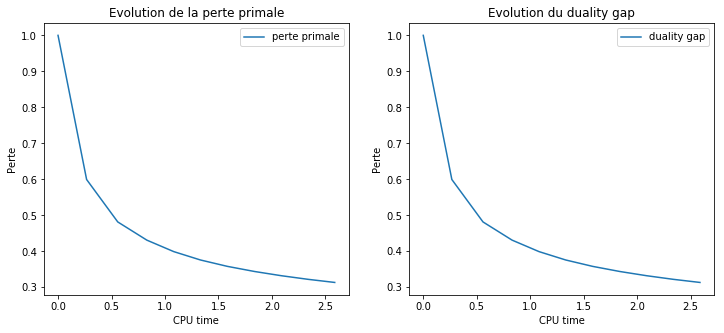

In [264]:
plt.figure(figsize=(12,5))
plt.plot([2,1])
plt.subplot(121)
plt.plot(np.cumsum(timelaps), primal_loss_track , label="perte primale")
plt.ylabel("Perte")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution de la perte primale")

plt.subplot(122)
plt.plot(np.cumsum(timelaps), gaps_track , label="duality gap")
plt.ylabel("Perte")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution du duality gap")
plt.show()

### On introduit une Stochastic Gradient Descent pour la premiere epoch

##### Cas du primal avec hinge loss

On appelle $S$ un ensemble de points, $x_i \in \mathbb{R}^{n}$ et les labels correspondants, $y_i \in \{−1,1\}$. On cherche un hyperplan qui minimiserait la hinge loss totale.

\begin{equation}
w^* = \underset{w}{\text{argmin }} L^{hinge}_S(w) = \underset{w}{\text{argmin }} \sum_i{l_{hinge}(w,x_i,y_i)}= \underset{w}{\text{argmin }} \sum_i{\max{\{0,1-y_iw\cdot x_i}\}}
\end{equation}

On identifie le gradient:

$$\frac{\partial{l_{hinge}}}{\partial w}=
\begin{cases}
  0  & y_iw\cdot x_i \geq 1 \\
  -y_ix & y_iw\cdot x_i < 1
\end{cases}$$

On obtient alors l'update suivant

$$w^{t+1}=\left(1-\frac{1}{t}\right)w^{t} - \frac{1|(y_i w^{t}\cdot x_i)}{\lambda t}x_i$$

##### Cas du dual avec hinge loss

Soit $t \in \{1,...,n\}$


Puisque pour la *Stochastic Gradient Descent*, on update selon une seule observation $t$ à chaque fois, l'objectif est de choisir le réel $\alpha_t$ qui maximise : 
$$ - \frac{1}{n} \phi_t^{\star}(-\alpha_t) - \frac{\lambda}{2} ||w^{t}||^2$$
Or, on a:
$$ \begin{align}
w^{t} = &  w^{t-1} + \Delta w\\
 = & w^{t-1} + \frac{1}{\lambda n}\sum_{i = 1}^{n} \Delta \alpha _{i} x_i\\
 = & w^{t-1} + \frac{1}{\lambda n} \Delta \alpha _{t} x_t \\
 = & w^{t-1} + \frac{1}{\lambda n} \alpha _{t} x_t \\
\end{align}$$
En effet, $\alpha_t$ est initialisé à 0 et le SGD sert à la première epoch seulement. On se retrouve donc à maximiser:

$$ - \phi_t^{\star}(-\alpha_t) - \frac{\lambda n}{2} ||w^{t-1} + \frac{1}{\lambda n} \alpha _{t} x_t ||^2$$

En développant : 
$$ \alpha_t y_t - \frac{\lambda n}{2} \left( ||w^{t-1}||^2 + 2 \frac{\alpha_t}{\lambda n} \langle w^{t-1}, x_t \rangle + \frac{\alpha_t^2}{\lambda^2 n^2}||x_t||^2 \right)$$

L'expression est concave du fait du terme de second ordre négatif. L'extremum sera donc un maximum. On applique la formule du maximizer dans un polynome de degré 2:
$$ \alpha_t^{\star}= \frac{\lambda n}{||x_t||^2} \left(y_t - x_t^T w^{t-1}\right)$$


Il faut toutefois éviter d'avoir une dual loss infinie. Il faut donc que $-\alpha_t^{\star}y \in [-1,0] \Leftrightarrow \alpha_t^{\star}y \in [0,1]$

On peut donc adapter l'algorithme pour qu'il incorpore un SGD pour la première epoch.

On commence par compléter le wrapper

In [301]:
def hinge_sgd_update(y, w, x, t, lamb):    
    """
        Calcule l'update SGD pour la premiere epoch
        w: vecteur des poids primaux
        x: variables explicatives de l'observation t
        y: label a predire
        lamb: regularisation
    """
    alpha_star=((lamb * t) /  (np.linalg.norm(x)**2)) * (y - np.dot(x.T, w))
    return alpha_star

hinge.set_sgd_update(hinge_sgd_update)

In [329]:
def SDCA_sgd (X, y, T, lossfunction, gamma, T_0_ratio, epsilon, lamb, SGD_init):
    """
        Algorithme SDCA, avec SGD eventuel pour la premiere epoch
        X: variables explicatives
        y: label a predire
        T: nombre d'epoch
        lossfunction: choix de la loss function
        gamma: parametre de smoothing, 1 etant tres smooth
        T_0_ratio: fraction qui indique quelle part des iterations on conserve
                    pour moyenner et obtenir alpha et w finaux
        lamb: regularisation
        SGD_init: initialisation premiere epoch par SGD
    """
    n_samples = X.shape[1]
    n_features=X.shape[0]
    Alpha=[]
    alpha= [0] * n_samples
    Alpha.append(alpha.copy())
    
    # On enregistre la primal loss
    primal_loss_track = []
    w = w_from_alpha(alpha, X, lamb)
    primal_loss_track.append(cum_loss_primal(w, X, y, lamb, lossfunction))
    
    # On enregistre la dual loss
    dual_loss_track = []
    dual_loss_track.append(cum_loss_dual(np.array(Alpha[0]), X, y, lamb, lossfunction))
    
    # On enregistre le duality gap
    gaps_track = []
    gap = duality_gap(np.array(Alpha[0]), X, y, lamb, lossfunction)
    gaps_track.append(gap)

    t = 0
    timelaps = [0]
    dual_loss=epsilon+1
    
    
    while (gap > epsilon) and (t < T) :
        start = time.perf_counter()
        indices = np.array(range(0, n_samples))
        np.random.shuffle(indices)
        for i in range(0, n_samples):
            j = indices[i]
            
            # Initialisation eventuelle SGD, on doit cette fois prendre les coordonnees dans l'ordre
            if (t==0):
                alpha[i] = lossfunction.sgd_update(y[i], w, X[:, i], i, lamb)
                # Du fait de la dimension de alpha, on update w manuellement, coordonnee par coordonnee
                w *= float(i) / float(i + 1)
                w += (1 / (lamb * (i + 1))) * np.array(alpha[i]) * np.array(X[:, i])
                
             # Sinon SDCA standard
            else:
                delta_alpha = lossfunction.sdca_update(y[j], w, X[:,j], n_samples, lamb, alpha[j], gamma)
                alpha[j] += delta_alpha
                w += (1 / (lamb * n_samples)) * delta_alpha * X[:,j]
        
        
        end = time.perf_counter()
        timelaps.append(end - start)
        #A la fin de chaque epoch, on enregistre
        # alpha
        Alpha.append(alpha.copy())
        # la primal loss
        primal_loss_track.append(cum_loss_primal(w, X, y, lamb, lossfunction))
        # la dual loss
        dual_loss=cum_loss_dual(np.array(alpha), X, y, lamb, lossfunction)
        dual_loss_track.append(cum_loss_dual(np.array(alpha), X, y, lamb, lossfunction))
        # le duality gap
        gap = duality_gap(np.array(alpha), X, y, lamb, lossfunction)
        gaps_track.append(gap)
        t += 1
    
    # Une fois que l'algorithme a converge, on recupere les weights a partir de la matrice alpha
    alpha_bar = np.mean(Alpha[-int(T_0_ratio*T):],axis=0)
    w_bar = w_from_alpha(alpha_bar,X, lamb)
    
    # Sortie aleatoire
    k = np.random.randint(int(T_0_ratio*T),T-2)
    alpha_rand = Alpha[k]
    w_rand=w_from_alpha(alpha_rand, X, lamb)
    
    return(Alpha, timelaps, primal_loss_track, dual_loss_track, gaps_track, w_bar, w_rand)

### Résultats pour les données simulées

In [340]:
T = 20
lossfunction = hinge
gamma = 1.0
T_0_ratio = 1/2
epsilon =1e-7 
lamb = 1e-7
SGD_init=True

[Alpha, timelaps, primal_loss_track, dual_loss_track, gaps_track, w_bar, w_rand]=(SDCA_sgd(X,
                                                                                       y, 
                                                                                       T, 
                                                                                       lossfunction, 
                                                                                       gamma,
                                                                                       T_0_ratio,
                                                                                       epsilon,
                                                                                       lamb,
                                                                                        SGD_init))

On compare les poids obtenus par la méthode de la moyenne et celle du choix aléatoire aux vrais poids

In [341]:
w = PrettyTable()
w.add_column("poids initiaux",w_real)
w.add_column("poids obtenus par moyenne",w_bar)
w.add_column("poids obtenus par alea",w_rand)
print (w)

+------------------+---------------------------+------------------------+
|  poids initiaux  | poids obtenus par moyenne | poids obtenus par alea |
+------------------+---------------------------+------------------------+
|  -1.07098299215  |       -2.72506142336      |     -3.22219551914     |
| -0.489818333119  |       -1.09676860584      |     -1.30822289043     |
|  -0.95346729359  |       -2.40089258553      |     -2.80877262505     |
| -0.220977406758  |      -0.450561026796      |    -0.503218090785     |
|  0.59970628039   |       1.48229464062       |     1.70957099454      |
| -0.462579867266  |       -1.01015706514      |     -1.20112728673     |
|  0.482056986216  |       1.12134159167       |     1.28297518822      |
|  1.48394193281   |       3.50782381268       |     4.07978166497      |
|  0.143741095077  |       0.215668205448      |     0.191399978568     |
| -0.424495077651  |       -1.11791158289      |     -1.31312075506     |
| -0.816749962376  |       -1.91302933

On regarde l'évolution de la perte primale et du duality gap

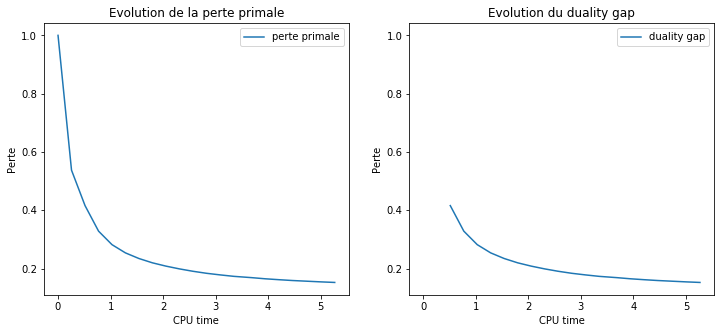

In [343]:
plt.figure(figsize=(12,5))
plt.plot([2,1])
plt.subplot(121)
plt.plot(np.cumsum(timelaps), primal_loss_track , label="perte primale")
plt.ylabel("Perte")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution de la perte primale")

plt.subplot(122)
plt.plot(np.cumsum(timelaps), gaps_track , label="duality gap")
plt.ylabel("Perte")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution du duality gap")
plt.show()